# Lab Sprint: Multiscale organization of social brain networks

# Age and Sex Effects

2-4 August 2022

Script author: Bianca Serio

## Load packages

In [190]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv

# Computing
import scipy.io  # loadmat
import mat73  # loadmat 
import statistics
from scipy import stats

# Visualisation
import matplotlib.pyplot as plt 

## Define directories

In [276]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/pt_02542/social_networks/data/'

resdir = '/data/pt_02542/social_networks/results/'
#os.makedirs(resdir, exist_ok=True)

# Descriptives

## Load Data

In [153]:
demographics = pd.read_csv(datadir+'HCP_426unrelatedSub_phenotype.csv')

In [154]:
print(f"N = {len(demographics)}\n"
      f"{np.sum(demographics.Gender == 'F')} females, {np.sum(demographics.Gender == 'M')} males\n"
      f"Mean subject age: {np.mean(demographics.Age_in_Yrs):.2f}, SD: {np.std(demographics.Age_in_Yrs):.2f}, range: {np.min(demographics.Age_in_Yrs):.2f} - {np.max(demographics.Age_in_Yrs):.2f}\n"
      f"Mean ICV: {np.mean(demographics.FS_IntraCranial_Vol):.2f}, SD: {np.std(demographics.FS_IntraCranial_Vol):.2f}, range: {np.min(demographics.FS_IntraCranial_Vol):.2f} - {np.max(demographics.FS_IntraCranial_Vol):.2f}")

N = 426
225 females, 201 males
Mean subject age: 28.60, SD: 3.67, range: 22.00 - 36.00
Mean ICV: 1585739.06, SD: 184777.78, range: 831208.30 - 1998044.32


## Testing differences in age between the sexes (given that I will test sex and age effects without matching sex-age)

In [155]:
# Levene's test for equality of variances -> non-significant differences means equality, can contiunue with parametric independent samples t-test
stats.levene(demographics.Age_in_Yrs[demographics.Gender == 'M'], demographics.Age_in_Yrs[demographics.Gender == 'F'])

LeveneResult(statistic=0.4557898237962922, pvalue=0.4999661929937028)

In [156]:
stats.ttest_ind(demographics.Age_in_Yrs[demographics.Gender == 'M'], demographics.Age_in_Yrs[demographics.Gender == 'F'])

Ttest_indResult(statistic=-4.875214839068324, pvalue=1.5392502822237055e-06)

Text(0, 0.5, 'Frequency')

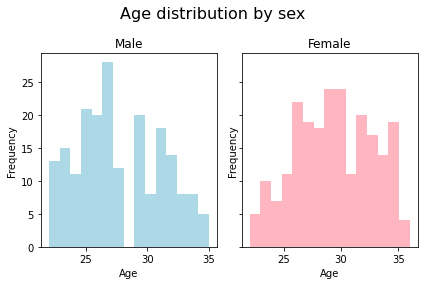

In [157]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

fig.suptitle('Age distribution by sex', fontsize=16)

axs[0].hist(demographics.Age_in_Yrs[demographics.Gender == 'M'], bins=15, color = 'lightblue')
axs[0].set_title('Male')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

axs[1].hist(demographics.Age_in_Yrs[demographics.Gender == 'F'], bins=15, color = 'lightpink')
axs[1].set_title('Female')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

# Preparing brain data for linear regression (in R)

## SJH cluster mask

i.e., in SJH parcellation (1010 parcels), parcels inside mask of interest (1), parcels outside (0)

number of SJH parcels in mask: 462

In [202]:
sjh_cluster_1010_mask = pd.read_csv('/data/pt_02542/social_networks/data/sjh_cluster_1010_mask.txt', sep=' ', header=None)

In [211]:
# index of values corresponding to the mask of interest -> will use this to cut the 1012x1012 matrices
index_mask_462 = sjh_cluster_1010_mask.index[sjh_cluster_1010_mask[0] == 1].tolist()

## MPC

### Raw data (i.e., MPC intensity profiles (averaged over 16 layers) in each parcel)
**-> PROBLEM: Bin & Alex's data is individual level connectivity matrices - I would need the step just before no? raw data**

**-> CONT.: raw data = Lina's data, BUT hers is in fsaverage vertices so I would need to project fsaverage -> sjh (and then apply mask)**

#### MPC pairwise connectivity matrices (sjh parcellation, unmasked) computed by Bin & Alex

each subject (out of 426) has: 1010 parcels x 1010 parcels 

#### Lina's (Matlab) -example code for:
- MPC data: in the format of layers x vertices/parcels x subjects
- manipulating wholebrain fsaverage5 vertices
- applying masks (activation-based meta-analytical map mask + midline wall mask)

**last subsection in this section calculates the mean MPC for MPC sex and age lm analyses** (exports mean to txt file for analyses in R)

**other than that, not used for project analyses because it's fsaverage parcellation (not SJH)**

##### Wholebrain 

fsaverage5: 20484 vertices; first half of the array is left hemisphere and second half is right (fsaverage convention)

In [186]:
mpc = mat73.loadmat('/data/pt_02542/social_networks/results/mpc/matlab_made_by_lina/intensity_profiles_wholebrain.mat')
# 12 (layers) x 20484 (vertices) x 1101 (sub -> full sample)

Calculate the mean mpc (across 12 layers) value per vertex per subject (mpc is still in full sample N = 1101)

In [15]:
# calculate the mean mpc value per vertex per subject and store it in a list which will contain 1101 (sub) x 20484 (vertices)
mpc_means = []

for sub in mpc['BB_all'].T:
    temp_sub = []
    
    for vertex in sub:
        temp_mean_vertex = 0
        temp_mean_vertex = statistics.mean(vertex)  # takes the mean of the 12 layers
        temp_sub.append(temp_mean_vertex)
    
    mpc_means.append(temp_sub)    

# dataframe containing 1101 rows (participants) x 20484 columns (vertices): content values are the mean mpc across 12 layers    
df_mpc_means_wholebrain = pd.DataFrame(mpc_means)

In [162]:
df_mpc_means_wholebrain

0         1         2         3         4         5         6      \
0     2.000461  1.767805  1.626661  1.790237  1.893281  1.682160  1.801187   
1     2.174153  1.736753  1.703559  1.644420  1.903188  1.621496  1.901350   
2     2.257156  2.037592  1.810788  1.808471  1.797940  1.610294  1.793024   
3     2.545038  1.714274  2.001156  2.204234  2.356803  1.916110  1.911009   
4     2.231686  1.731238  1.907962  1.764206  1.978865  1.728274  1.954220   
...        ...       ...       ...       ...       ...       ...       ...   
1096  2.167738  1.711667  1.551511  1.662949  1.612842  1.616801  1.754872   
1097  2.286734  1.853452  1.926306  1.629814  1.974333  1.864594  1.987045   
1098  2.087103  1.832445  1.862363  1.783108  1.806915  1.681400  1.892178   
1099  2.576662  2.253352  2.554928  1.897771  1.909763  2.112520  2.103706   
1100  1.984598  1.672882  1.758679  1.717251  1.814188  1.412256  1.882280   

         7         8         9      ...     20474     20475     20476  \
0     1.808154  1.848937  1.935242  ...  1.608645  1.627179  1.593380   
1     1.866272  1.634727  1.753514  ...  1.472344  1.601802  1.361401   
2     1.825155  1.804319  1.828903  ...  1.639612  1.378683  1.620305   
3     2.006492  2.949324  2.563377  ...  1.556775  1.572407  1.469532   
4     1.966234  0.414039  1.974718  ...  1.800537  1.717592  2.065045   
...        ...       ...       ...  ...       ...       ...       ...   
1096  1.462365  1.373346  1.623800  ...  1.492997  1.634726  1.392594   
1097  2.443951  1.998489  1.758896  ...  1.668942  1.540204  1.697367   
1098  1.892459  1.538533  1.693448  ...  1.391550  1.409903  1.368373   
1099  2.434849  1.978484  1.913547  ...  1.655112  1.538816  1.673089   
1100  1.878107  1.626960  1.634647  ...  1.496337  1.283072  1.457492   

         20477     20478     20479     20480     20481     20482     20483  
0     1.436093  1.707282  1.470818  1.515555  1.420999  1.605552  1.889388  
1     1.450294  1.366128  1.419077  1.450180  1.584109  1.823018  1.986701  
2     1.348348  1.504331  1.452196  1.529935  1.544274  1.453838  1.541041  
3     1.538280  1.915211  1.484559  1.366107  1.742164  1.612746  1.859857  
4     2.231532  1.753708  1.686569  1.622884  1.919786  2.077985  2.109041  
...        ...       ...       ...       ...       ...       ...       ...  
1096  1.391636  1.530879  1.469312  1.416831  1.579190  1.596682  1.614222  
1097  1.430471  1.526475  1.513034  1.716360  1.309412  1.471599  1.697034  
1098  1.785488  1.623389  1.490000  1.485327  1.745581  1.669378  1.723214  
1099  1.548260  1.406275  1.646929  1.546698  1.690821  1.655628  1.865741  
1100  1.456470  1.522869  1.443298  1.848533  1.523554  1.562484  1.500031  

[1101 rows x 20484 columns]

Make a df_mpc_means_wholebrain that only contains unrelated subjects 

In [174]:
# list of full sample subject IDs (N = 1101) corresponding to subjects in Lina's matfile (in same order)
full_sub_list = pd.read_csv('/data/pt_02542/social_networks/results/mpc/matlab_made_by_lina/fulllist.txt', sep=' ', header=None)

# list of unrelated sample subject IDs (n = 426) from demographics dataframe (data loaded in descriptives section)
unrel_sub_list = demographics['Subject'].tolist()

# list of the indexes of unrelated subjects in the full sample dataframe 
index_unrel_sub = full_sub_list.index[full_sub_list[0].isin(unrel_sub_list)].tolist()

# select (with index_unrel_sub) from df_mpc_means_wholebrain dataframe only rows corresponding to unrelated subjects 
df_mpc_means_wholebrain_unrel_sub = df_mpc_means_wholebrain.loc[index_unrel_sub]

In [175]:
df_mpc_means_wholebrain_unrel_sub

0         1         2         3         4         5         6      \
0     2.000461  1.767805  1.626661  1.790237  1.893281  1.682160  1.801187   
1     2.174153  1.736753  1.703559  1.644420  1.903188  1.621496  1.901350   
2     2.257156  2.037592  1.810788  1.808471  1.797940  1.610294  1.793024   
3     2.545038  1.714274  2.001156  2.204234  2.356803  1.916110  1.911009   
4     2.231686  1.731238  1.907962  1.764206  1.978865  1.728274  1.954220   
...        ...       ...       ...       ...       ...       ...       ...   
1036  1.908414  1.781555  1.659760  1.828432  1.972391  1.683701  2.027914   
1057  2.454074  1.619065  2.067376  1.900855  1.856735  1.728323  1.666236   
1069  2.277170  2.033686  1.879270  2.181865  2.229678  1.680294  1.801140   
1073  1.949268  1.753848  2.037628  1.965520  2.106331  1.719512  1.565443   
1080  1.980550  1.743128  1.847090  1.613226  1.764619  1.591565  1.719271   

         7         8         9      ...     20474     20475     20476  \
0     1.808154  1.848937  1.935242  ...  1.608645  1.627179  1.593380   
1     1.866272  1.634727  1.753514  ...  1.472344  1.601802  1.361401   
2     1.825155  1.804319  1.828903  ...  1.639612  1.378683  1.620305   
3     2.006492  2.949324  2.563377  ...  1.556775  1.572407  1.469532   
4     1.966234  0.414039  1.974718  ...  1.800537  1.717592  2.065045   
...        ...       ...       ...  ...       ...       ...       ...   
1036  1.778670  0.486577  1.914576  ...  1.565383  1.492884  1.480382   
1057  1.604520  2.071300  2.048840  ...  1.624948  1.553646  1.553594   
1069  2.111539  0.342290  2.038290  ...  1.707393  1.694337  1.731360   
1073  2.028048  2.937064  1.853679  ...  1.559744  1.432147  1.476025   
1080  1.821593  0.864354  1.658839  ...  1.623366  1.680368  1.630235   

         20477     20478     20479     20480     20481     20482     20483  
0     1.436093  1.707282  1.470818  1.515555  1.420999  1.605552  1.889388  
1     1.450294  1.366128  1.419077  1.450180  1.584109  1.823018  1.986701  
2     1.348348  1.504331  1.452196  1.529935  1.544274  1.453838  1.541041  
3     1.538280  1.915211  1.484559  1.366107  1.742164  1.612746  1.859857  
4     2.231532  1.753708  1.686569  1.622884  1.919786  2.077985  2.109041  
...        ...       ...       ...       ...       ...       ...       ...  
1036  1.293031  1.403323  1.239721  1.371714  1.569875  1.485799  1.728444  
1057  1.494731  1.791131  1.654571  1.687741  1.650664  1.573858  1.747165  
1069  1.581371  1.767588  1.495633  1.798281  1.757954  2.005455  1.769723  
1073  1.323513  1.382417  1.407095  1.383109  1.572093  1.490209  1.458300  
1080  1.525183  1.356100  1.482166  1.457619  1.389449  1.520281  1.752783  

[426 rows x 20484 columns]

##### Use thresholded maps to select (from wholebrain) only the vertices that belong to the mask of interest


- Mask of interest: total size = 9197 vertices (without medial wall!)
    - Full map yielded from Cl_all_thresh.10k_fsavg5.L.csv: 10146 vertices (including medial wall) 
    - Medial wall (is provided by fsa5_rh_mask.csv fsa5_rh_mask.csv): 949 -> to remove from full map
    
*Reason to remove medial wall: because when transforming from volume to surface, values from e.g. subcortical structures get projected to the medial wall, introducing inaccuracies. Thus, excluding it to focus on only the cortex is a standardization method*

In [176]:
# read the thresholded maps (by hemisphere)
# size = 10242 vertices (fsaverage5) for each thresholded map, where vertices belonging to mask of interest != 0

# left hemisphere thresholded map

with open('/data/pt_02542/social_networks/data/MetaAnalysis_Maps/TransformedData_fsaverage5/Cl_all_thresh.10k_fsavg5.L.csv', newline='') as f:
    reader = csv.reader(f)
    data_all_cl_L = list(reader)

# make thresholded maps into arrays (by first extracting every vertex value from the sublist it is in (as a result of csv.reader)
all_cl_L = []
for i in data_all_cl_L:
    all_cl_L.append(i[0])

all_cl_L = np.asarray(all_cl_L).astype('float64')  # .astype('float64') to change from scientific notation


# right hemisphere thresholded map

with open('/data/pt_02542/social_networks/data/MetaAnalysis_Maps/TransformedData_fsaverage5/Cl_all_thresh.10k_fsavg5.R.csv', newline='') as f:
    reader = csv.reader(f)
    data_all_cl_R = list(reader)

# make thresholded maps into arrays (by first extracting every vertex value from the sublist it is in (as a result of csv.reader)
all_cl_R = []
for i in data_all_cl_R:
    all_cl_R.append(i[0])

all_cl_R = np.asarray(all_cl_R).astype('float64')  # .astype('float64') to change from scientific notation

In [177]:
# concatenate the hemisphere thresholded maps with one another to make a wholebrain thresholded map (following the fsaverage convention: first left hemisphere, then right hemisphere)
all_cl_wholebrain = np.concatenate((all_cl_L, all_cl_R), axis = 0)

Remove the medial wall

In [179]:
# Medial wall masks, i.e., file encodes which parcels represent the medial wall in the hemispheres of fsa5
# Every index is a parcel number, and the associated values signify if that parcel is part of the medial wall (0) or not (1)
# You can thus use it to mask the medial wall in your fsavg5 arrays by substituting np.NaN in your array at the same location where the array from this file has a 0
fsa5_lh_mask = pd.read_csv('/data/pt_02542/social_networks/sources/fsa5_lh_mask.csv', header = None)
fsa5_rh_mask = pd.read_csv('/data/pt_02542/social_networks/sources/fsa5_rh_mask.csv', header = None)

# concatenate the medial wall thresholded maps with one another to make a wholebrain medial wall thresholded map (following the fsaverage convention: first left hemisphere, then right hemisphere)
fsa5_wholebrain_mask = np.concatenate((fsa5_lh_mask[0].tolist(), fsa5_rh_mask[0].tolist()), axis = 0)

In [182]:
# creating a new list containing the thresholded map with removed medial wall from wholebrain (i.e. turning into 0 values that are part of the medial wall (0 in fsa5_wholebrain_mask)) 

all_cl_wholebrain_medialwall_removed = []

# looping over all 20484 fsaverage vertices
for i in range(len(all_cl_wholebrain)):
    
    # if the current vertex is part of the medial wall -> code it as 0 in all_cl_wholebrain_medialwall_removed 
    if fsa5_wholebrain_mask[i] == 0:
        all_cl_wholebrain_medialwall_removed.append(0)
    
    # if the current vertex has a value other than zero in the mask -> code it with whatever value that vertex has in the thresholded map (mask)
    else:
        all_cl_wholebrain_medialwall_removed.append(all_cl_wholebrain[i])

# this is final thresholded map array representing (with values != 0) vertices belonging to the mask of interest (without medial wall)
all_cl_wholebrain_medialwall_removed = np.asarray(all_cl_wholebrain_medialwall_removed)

In [183]:
# retrieving the indexes of vertices belonging to the final mask of interest (without medial wall), i.e., where value != 0
index_mask_wholebrain = np.where(all_cl_wholebrain_medialwall_removed != 0)[0]

**final dataframe mpc raw data (MPC intensity profiles - mean across 12 layers) - individual-subject level** - this format could be used for R analyses if I was doing them at vertex level

**426 rows (subjects) x 9197 columns (vertices from mask) -> values represent average mpc across 12 layers**

In [185]:
# creating a subset of the df_mpc_means_wholebrain which only contains the vertices belonging to the mask
# ACHTUNG! to note that the column and row labels are not indexes 0-max but index before subselection, so careful when indexing -> maybe should just relabel them to avoid erros
df_mpc_means_masked_9197v = df_mpc_means_wholebrain_unrel_sub[index_mask_wholebrain]
df_mpc_means_masked_9197v

4         9         10        12        16        21        22     \
0     1.893281  1.935242  1.836077  1.996196  1.560392  1.686469  1.719342   
1     1.903188  1.753514  1.596652  1.960138  1.788754  1.508702  1.525069   
2     1.797940  1.828903  1.814869  1.924066  1.807365  1.690842  1.607376   
3     2.356803  2.563377  2.003943  2.556389  1.883247  2.132923  2.628801   
4     1.978865  1.974718  1.759196  2.146112  1.725259  1.649810  1.763318   
...        ...       ...       ...       ...       ...       ...       ...   
1036  1.972391  1.914576  1.930385  1.914466  1.842221  1.657078  1.899628   
1057  1.856735  2.048840  1.793901  2.142366  1.593719  1.672127  1.729530   
1069  2.229678  2.038290  2.029122  2.060589  2.123808  1.801695  1.593248   
1073  2.106331  1.853679  1.703474  2.020778  1.593446  1.719864  1.627489   
1080  1.764619  1.658839  1.712090  1.799886  1.516939  1.569211  1.479595   

         26        28        29     ...     20465     20466     20467  \
0     1.836448  1.922759  1.689077  ...  1.585138  1.605814  1.559319   
1     1.770393  1.732095  1.706800  ...  1.420815  1.503979  1.589009   
2     1.786373  1.708823  1.721229  ...  1.503931  1.356075  1.547114   
3     2.357618  2.136293  1.776450  ...  1.659749  1.563872  1.629112   
4     1.876656  1.871773  1.571680  ...  1.803422  1.778276  1.606708   
...        ...       ...       ...  ...       ...       ...       ...   
1036  1.854850  1.850641  1.503924  ...  1.724957  1.558331  1.603307   
1057  1.943553  2.250063  1.599129  ...  1.721427  1.634397  1.420103   
1069  2.086979  2.039752  1.482456  ...  1.714749  1.685091  1.352299   
1073  1.752680  2.000380  1.542313  ...  1.881615  1.571821  1.485398   
1080  1.738302  1.773801  1.442167  ...  1.579790  1.692526  1.436856   

         20468     20469     20470     20471     20472     20473     20474  
0     1.570368  1.634970  1.644049  1.749788  1.670215  1.592911  1.608645  
1     1.536603  1.531791  1.620041  1.654288  1.527478  1.596446  1.472344  
2     1.551639  1.559163  1.610675  1.719584  1.685226  1.707401  1.639612  
3     1.560361  1.614971  1.832248  1.734239  1.516639  1.604742  1.556775  
4     1.669859  1.812810  1.814306  1.773683  1.787721  1.812351  1.800537  
...        ...       ...       ...       ...       ...       ...       ...  
1036  1.615151  1.587072  1.495125  1.669055  1.618040  1.703634  1.565383  
1057  1.589100  1.592187  1.731779  1.568706  1.614031  1.597686  1.624948  
1069  1.616908  1.674878  1.589018  1.376777  1.618642  1.736108  1.707393  
1073  1.570942  1.432158  1.545670  1.510698  1.453667  1.557517  1.559744  
1080  1.569103  1.553551  1.630402  1.607509  1.562196  1.518578  1.623366  

[426 rows x 9197 columns]

##### Calculate the **mean mpc across parcels** for each subject -> for mpc sex and age lm analyses (in R), i.e., to include in model as covariate
Mean across all parcels/vertices (covariate) per subject -> because of parcel artifacts for each specific subject (intensity of t1/t2 could vary by subject)

Potential problem with how I did this:
- already check that this is the mean that Svenja meant, i.e. mean across layers, across vertices - per subject (ie one value per subject)
- this was calculated at the masked vertex level - while it should technically be the same as if calculated a the masked sjh parcel level (because parcels are made of means over vertices), the fact that I went through the process of applying the mask over the vertices, removing the midline etc myself could make the vertex vs parcel solutions not match exactly

In [411]:
# list will contain the mean of all mpc intensities (mean across vertices) per subjects (len = 426, ie number of subjects)
means_mpc_9197v = []

# iterate over rows (subjects) of dataframe
for i in range(len(df_mpc_means_masked_9197v)):
    means_mpc_9197v.append(np.mean(df_mpc_means_masked_9197v.iloc[i]))   

In [416]:
# fmt = decimals, header = 1 to 463 (without the first and last string letter because it's the [] of the list, comments = empty because otherwise gives a #

np.savetxt(resdir+'age_sex/'+'means_mpc_9197v.csv', means_mpc_9197v, delimiter=',', header = 'mpc_means')#, fmt = '%.16g', header = str(list(range(1,463)))[1:-1], comments = '')

### Gradient eigenvalues

#### MPC gradients (mask on sjh parcellation) computed by Bin & Alex

each subject (out of 426) has: 462 parcels x 10 gradients -> I am taking, from each subject, just G1 for all parcels

this yields arrays of  426 subjects x 462 G1 eigenvalues (for mpc within and between separately)

In [315]:
path_list_mpc_pairwise_grad = os.listdir(resdir+'mpc/individual_pairwise_grad/')
path_list_mpc_pairwise_grad.sort()

In [359]:
# list that contains all the subject IDs of subjects with fc matrices - not planning on doing anything with this, but good to have as sanity check
sub_list_mpc_pairwise_within_grad = []
sub_list_mpc_pairwise_rest_grad = []

# lists that contains the mpc gradient matrices of all subjects in the form of 1 np array per subject
#list "within" contains connectivity within mask of interest, list "rest" contains connectivity mask to rest of brain
mpc_pairwise_within_grad_462 = []
mpc_pairwise_rest_grad_462 = []


for e in path_list_mpc_pairwise_grad:
    if '.txt' in e:  # just in case so don't call on hidden ipynb_checkpoints in the path list matrices
        
        # identify if rest or within mpc in order to sort subject gradient data in the correct list
        conn_type = e.split("_")[2]  # this splits the string subID_all_within_sjh.txt into a list of 4 occurences containing ('subID', 'all', 'rest/within', 'sjh.txt'), and I keep only the rest/within
        
        # reads txt file in the form of an array, taking just the 1st value (G1) directly
        sub_G1 = np.genfromtxt(resdir+'mpc/individual_pairwise_grad/'+e, delimiter=' ').T[0]
        
        if conn_type == 'within':
            
            # add subject to the subjects' list
            sub_list_mpc_pairwise_within_grad.append(e.split("_")[0])  # this partitions the subID_all_within_sjh.txt into a list of 4 occurences containing ('subID', 'all', 'rest/within', 'sjh.txt'), and I keep only the subID
        
            # add subject's matrix to the mpc_pairwise_within_grad_1010 list
            mpc_pairwise_within_grad_462.append(sub_G1)
            
        elif conn_type == 'rest':
            
            # add subject to the subjects' list
            sub_list_mpc_pairwise_rest_grad.append(e.split("_")[0])  # this partitions the subID_all_within_sjh.txt into a list of 4 occurences containing ('subID', 'all', 'rest/within', 'sjh.txt'), and I keep only the subID
        
            # add subject's matrix to the mpc_pairwise_rest_grad_1010 list
            mpc_pairwise_rest_grad_462.append(sub_G1)      

            
# make list into a numpy array - shape: 426 subjects x 462 parcels (containing each G1 eigenvalues)
array_G1_mpc_pairwise_within = np.array(mpc_pairwise_within_grad_462) 
array_G1_mpc_pairwise_between = np.array(mpc_pairwise_rest_grad_462)  # between = rest, just to keep consistent with fc terminology
            
print(f'number of MPC pairwise within gradient arrays (462 parcels x 1 gradient (G1)), i.e., subjects: N = {len(sub_list_mpc_pairwise_within_grad)}')
print(f'number of MPC pairwise rest gradient arrays (462 parcels x 1 gradients (G1)), i.e., subjects: N = {len(sub_list_mpc_pairwise_rest_grad)}')

number of MPC pairwise within gradient arrays (462 parcels x 1 gradient (G1)), i.e., subjects: N = 426
number of MPC pairwise rest gradient arrays (462 parcels x 1 gradients (G1)), i.e., subjects: N = 426


Exporting G1 arrays to csv for R analyses

In [358]:
# fmt = decimals, header = 1 to 463 (without the first and last string letter because it's the [] of the list, comments = empty because otherwise gives a #

np.savetxt(resdir+'age_sex/'+'array_G1_mpc_pairwise_within.csv', array_G1_mpc_pairwise_within, delimiter=',', fmt = '%.16g', header = str(list(range(1,463)))[1:-1], comments = '')
np.savetxt(resdir+'age_sex/'+'array_G1_mpc_pairwise_between.csv', array_G1_mpc_pairwise_between, delimiter=',', fmt = '%.16g', header = str(list(range(1,463)))[1:-1], comments = '')

## Functional

### Raw data (i.e., mean activation across timeseries in each parcel)
**->PROBLEM: I only have individual level connectivity matrices - I would need the step just before no? raw data**

### Gradient eigenvalues

In [268]:
fc_grad_between_1010 = scipy.io.loadmat('/data/pt_02542/social_networks/results/FC/individual/between_1010_10_426.mat')
# 1010 sjh parcels x 10 gradients x 426 sub

fc_grad_within_1010 = scipy.io.loadmat('/data/pt_02542/social_networks/results/FC/individual/within_1010_10_426.mat')
# 1010 sjh parcels x 10 gradients x 426 sub

In [269]:
# selecting only the parcels in the mask: new size is 462 sjh parcels x 10 gradients x 426 subjects
fc_grad_between_426 = fc_grad_between_1010['between_ind1010'][index_mask_462]
fc_grad_within_426 = fc_grad_within_1010['within_ind1010'][index_mask_462]

In [270]:
array_G1_fc_between = []
array_G1_fc_within = []

for i in range(len(sjh_parcels_462.T)):  # iterating over subjects
    
    # append to list
    array_G1_fc_between.append(fc_grad_between_426.T[i][0])  # gradient 1 for that subject
    array_G1_fc_within.append(fc_grad_within_426.T[i][0])  # gradient 1 for that subject

# make list into a numpy array - shape: 426 subjects x 462 parcels
array_G1_fc_between = np.array(array_G1_fc_between)  
array_G1_fc_within = np.array(array_G1_fc_within) 

Exporting G1 arrays to csv for R analyses

In [355]:
# fmt = decimals, header = 1 to 463 (without the first and last string letter because it's the [] of the list, comments = empty because otherwise gives a #

np.savetxt(resdir+'age_sex/'+'array_G1_fc_between.csv', array_G1_fc_between, delimiter=',', fmt = '%.16g', header = str(list(range(1,463)))[1:-1], comments = '')
np.savetxt(resdir+'age_sex/'+'array_G1_fc_within.csv', array_G1_fc_within, delimiter=',', fmt = '%.16g', header = str(list(range(1,463)))[1:-1], comments = '')